# [EXPLORATION-05] Kaggle 집값 예측

* 기본 baseline을 따라가되, 하이퍼파라메타에 대한 수정과 feature들을 약간씩 수정하여 진행한다.
* feature에 대한 고민도 중요하지만, 하이퍼파라미터에 집중해본다.

In [1]:
# 필요한 모듈 불러오기

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
# 데이터 불러오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [3]:
# 데이터 확인해보기
# date col에 대해 처리 해주어야 한다.

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

# 2. price 분포확인 및 불필요한 colums수정

* 한쪽으로 bias. 데이터를 로그변환 하여 정규성을 띄는 것 처럼 만들어 준다.
* 값에대해 로그변환 후 값을 예측하여 다시 re-scale 한다.

Text(0.5, 1.0, 'Price after change.')

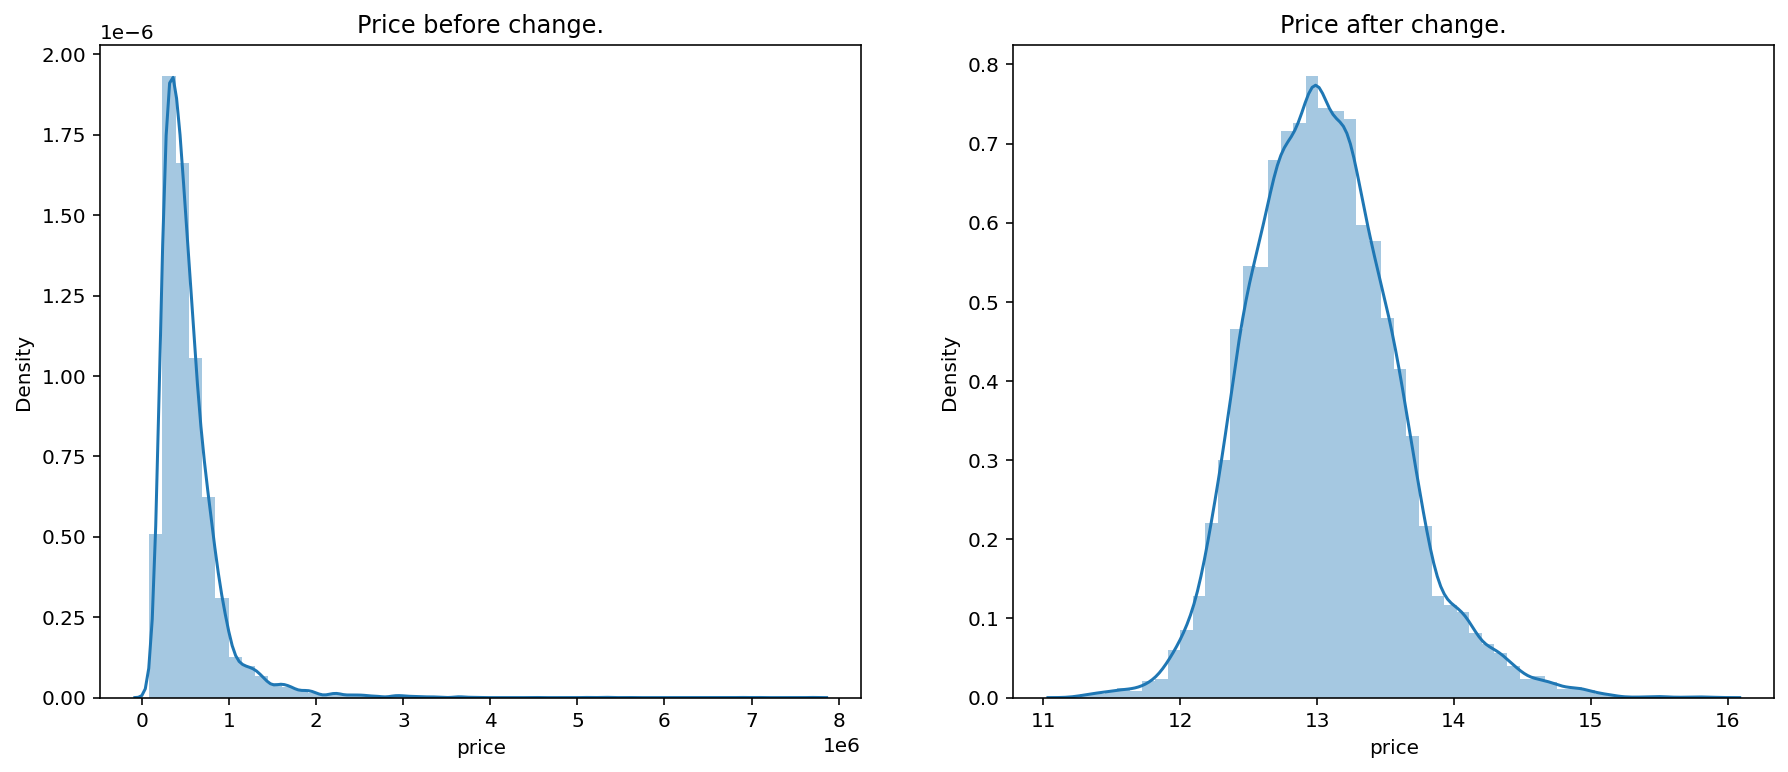

In [5]:
# price의 분포 확인 및 변경

y = train['price']
y_log_transformation = np.log1p(y) # 로그변환

f, ax = plt.subplots(figsize = (15, 6))
plt.subplot(121)
sns.distplot(y)
plt.title('Price before change.')

plt.subplot(122)
sns.distplot(y_log_transformation)
plt.title('Price after change.')

In [6]:
# 불필요한 Column 변경

train['date'] = train['date'].apply(lambda x: x[:6]).astype(int)
test['date'] = test['date'].apply(lambda x: x[:6]).astype(int)

y = train['price']
del train['price']
y = np.log1p(y) # price의 분포 변경

del train['id']
del test['id']

# 3. 모델링
* RandomForest Regressor
* GGradientBoosting Regressor
* XGB Regressor
* LGBM Regressor

RMSE를 계산 후 적절한 모델 선정하여 하이퍼 파라미터 튜닝

In [7]:
# 모델 선정
random_state=10

rdforest = RandomForestRegressor(random_state=random_state)
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)


models = [gboost, xgboost, lightgbm, rdforest]

In [8]:
# RMSE 계산하는 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [9]:
# 모델별 RMSE 계산
def model_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        model.fit(X_train, y_train)    # 모델 학습
        y_pred = model.predict(X_test) # 예측

        df[model_name] = rmse(y_test, y_pred) # 예측 결과의 rmse값 저장
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # data frame에 저장
            
    return score_df

model_scores(models, train, y)

,RMSE
RandomForestRegressor,123268.199875
GradientBoostingRegressor,119754.351943
XGBRegressor,109275.814110
LGBMRegressor,105180.592313


* LGBMRegressor의 RMSE가 105180으로 가장 성능이 좋음.
* 그렇다고 XGB가 성능이 상대적으로 낮지만 그렇다고 성능이 나쁘다 할 수 없음.
* LGBM을 이용하여 하이퍼 파라미터에 대한 그리드 서치를 진행한다.

# 4. 하이퍼 파라미터 튜닝

* GridSearchCV 메서드를 이용하여 최적의 하이퍼 파라미터를 찾으려 한다.


* n_estimators : 400, 450, 500, 550, 600, 650, 700
* max_depth : 9, 11, 13, 15, 17, 19, 21
* num_leaves: 15, 30, 45, 60
* learning_rate: 0.01, 0.03, 0.05, 0.07, 0.09


* 튜닝 시간 약 1시간 10분 소요

In [10]:
# GridSearch를 이용한 최적의 하이퍼파라미터 튜닝
def GridSearch_Tuning(model, train, y, param_grid, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [56]:
param_grid = {
    'n_estimators': [400, 450, 500, 550, 600, 650, 700],
    'max_depth': [9, 11, 13, 15, 17, 19, 21],
    'num_leaves': [15, 30, 45, 60],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09]
}
model = LGBMRegressor(random_state=random_state)
result = GridSearch_Tuning(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 980 candidates, totalling 4900 fits
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=60; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=60; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=30; total time=   2

[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=45; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=400, num_leaves=60; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, num_leaves=45; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, 

[CV] END learning_rate=0.01, max_depth=13, n_estimators=400, num_leaves=45; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=400, num_leaves=45; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=400, num_leaves=60; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=45; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=60; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=13, n_estimators=450, num_leaves=60; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=13, n_estim

[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=30; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=45; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=500, num_leaves=60; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=550, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=550, num_leaves=30; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=550, num_leaves=45; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=550, num_leaves=45; total time=   3.3s
[CV] END learning_rate=0.01, max_depth=15, n_estim

[CV] END learning_rate=0.01, max_depth=15, n_estimators=650, num_leaves=45; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=650, num_leaves=45; total time=   3.5s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=650, num_leaves=60; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=15; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=15; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=30; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=45; total time=   3.1s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=45; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=60; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=700, num_leaves=60; total time=   4.7s
[CV] END learning_rate=0.01, max_depth=17, n_estim

[CV] END learning_rate=0.01, max_depth=19, n_estimators=550, num_leaves=60; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=15; total time=   1.8s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=45; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=45; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=45; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=60; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=600, num_leaves=60; total time=   2.4s
[CV] END learning_rate=0.01, max_depth=19, n_estimators=650, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=19, n_estim

[CV] END learning_rate=0.01, max_depth=21, n_estimators=700, num_leaves=60; total time=   2.8s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.0s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=60; total time=   2.1s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=400, num_leaves=60; total time=   2.1s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=450, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=450,

[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=45; total time=   3.0s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.03, max_depth=9, n_estimators=700, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.03, max_depth=11, n_estimators=400, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.03, max_depth=11, n_estimators=400, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.03, max_depth=11, n_estimators=400, num_leaves=45; total time=   1.7s
[CV] END learning_rate=0.03, max_depth=11, n_estimators=4

[CV] END learning_rate=0.03, max_depth=13, n_estimators=400, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=400, num_leaves=45; total time=   1.9s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=400, num_leaves=45; total time=   2.1s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=400, num_leaves=60; total time=   2.2s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=450, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=450, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=450, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=450, num_leaves=45; total time=   2.3s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=450, num_leaves=60; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=13, n_estimators=500, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.03, max_depth=13, n_estim

[CV] END learning_rate=0.03, max_depth=15, n_estimators=550, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=550, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=550, num_leaves=45; total time=   1.6s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=550, num_leaves=45; total time=   2.5s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=550, num_leaves=60; total time=   3.0s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=600, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=600, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=600, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.03, max_depth=15, n_estimators=600, num_leaves=45; total time=   2.7s
[CV] END learning_rate=0.03, max_depth=15, n_estim

[CV] END learning_rate=0.03, max_depth=17, n_estimators=600, num_leaves=60; total time=   2.8s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=45; total time=   2.0s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=60; total time=   2.3s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=650, num_leaves=60; total time=   2.2s
[CV] END learning_rate=0.03, max_depth=17, n_estimators=700, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=17, n_estim

[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=30; total time=   1.0s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=60; total time=   1.6s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=450, num_leaves=60; total time=   1.5s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=500, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=500, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=500, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.03, max_depth=21, n_estim

[CV] END learning_rate=0.03, max_depth=21, n_estimators=700, num_leaves=45; total time=   3.1s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=700, num_leaves=60; total time=   3.7s
[CV] END learning_rate=0.03, max_depth=21, n_estimators=700, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=45; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=60; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=400, num_leaves=60; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=450, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=45

[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=30; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=45; total time=   1.6s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=45; total time=   1.6s
[CV] END learning_rate=0.05, max_depth=11, n_estim

[CV] END learning_rate=0.05, max_depth=13, n_estimators=550, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=45; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=13, n_estimators=600, num_leaves=45; total time=   2.6s
[CV] END learning_rate=0.05, max_depth=13, n_estim

[CV] END learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=15; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=30; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=45; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=45; total time=   3.1s
[CV] END learning_rate=0.05, max_depth=15, n_estimators=700, num_leaves=60; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=17, n_estimators=400, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=17, n_estimators=400, num_leaves=30; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=17, n_estimators=400, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=17, n_estimators=400, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=17, n_estimators=400, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=17, n_estim

[CV] END learning_rate=0.05, max_depth=19, n_estimators=400, num_leaves=30; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=400, num_leaves=45; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=400, num_leaves=45; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=400, num_leaves=60; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=400, num_leaves=60; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=450, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=450, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=450, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=450, num_leaves=30; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=19, n_estimators=450, num_leaves=30; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=19, n_estim

[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=30; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=45; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=45; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=60; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=600, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=21, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=21, n_estim

[CV] END learning_rate=0.07, max_depth=9, n_estimators=700, num_leaves=15; total time=   1.7s
[CV] END learning_rate=0.07, max_depth=9, n_estimators=700, num_leaves=30; total time=   2.6s
[CV] END learning_rate=0.07, max_depth=9, n_estimators=700, num_leaves=45; total time=   3.2s
[CV] END learning_rate=0.07, max_depth=9, n_estimators=700, num_leaves=45; total time=   2.8s
[CV] END learning_rate=0.07, max_depth=9, n_estimators=700, num_leaves=60; total time=   3.3s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=400, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=400, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=400, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=400, num_leaves=45; total time=   1.8s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=400, num_leaves=60; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=11, n_estimators

[CV] END learning_rate=0.07, max_depth=11, n_estimators=550, num_leaves=60; total time=   2.9s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=550, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=30; total time=   2.2s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=45; total time=   2.7s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=650, num_leaves=30; total time=   2.3s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=650, num_leaves=45; total time=   2.8s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=650, num_leaves=45; total time=   2.8s
[CV] END learning_rate=0.07, max_depth=11, n_estim

[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=45; total time=   2.7s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=45; total time=   2.7s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=650, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=700, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=700, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=700, num_leaves=30; total time=   2.3s
[CV] END learning_rate=0.07, max_depth=13, n_estimators=700, num_leaves=45; total time=   3.0s
[CV] END learning_rate=0.07, max_depth=13, n_estim

[CV] END learning_rate=0.07, max_depth=17, n_estimators=550, num_leaves=45; total time=   2.4s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=550, num_leaves=60; total time=   2.9s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=550, num_leaves=60; total time=   2.4s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=600, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=600, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=600, num_leaves=30; total time=   2.2s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=600, num_leaves=45; total time=   2.6s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=600, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=650, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.07, max_depth=17, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=17, n_estim

[CV] END learning_rate=0.07, max_depth=19, n_estimators=450, num_leaves=45; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=450, num_leaves=60; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=450, num_leaves=60; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=15; total time=   0.7s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=30; total time=   1.0s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=19, n_estimators=500, num_leaves=45; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=19, n_estim

[CV] END learning_rate=0.07, max_depth=21, n_estimators=550, num_leaves=60; total time=   2.9s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=45; total time=   2.5s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=45; total time=   2.5s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=600, num_leaves=60; total time=   2.6s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=650, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=650, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.07, max_depth=21, n_estimators=650, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.07, max_depth=21, n_estim

[CV] END learning_rate=0.09, max_depth=11, n_estimators=500, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=500, num_leaves=45; total time=   2.1s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=500, num_leaves=45; total time=   2.0s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=500, num_leaves=60; total time=   2.5s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=45; total time=   2.3s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=45; total time=   2.2s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=60; total time=   2.6s
[CV] END learning_rate=0.09, max_depth=11, n_estim

[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=45; total time=   2.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=550, num_leaves=60; total time=   2.8s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=30; total time=   1.9s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=45; total time=   2.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=45; total time=   1.9s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=600, num_leaves=60; total time=   2.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=650, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=650, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=11, n_estim

[CV] END learning_rate=0.09, max_depth=15, n_estimators=500, num_leaves=45; total time=   2.0s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=500, num_leaves=60; total time=   2.5s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=45; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.09, max_depth=15, n_estimators=550, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.09, max_depth=15, n_estim

[CV] END learning_rate=0.09, max_depth=17, n_estimators=700, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=17, n_estimators=700, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=17, n_estimators=700, num_leaves=45; total time=   2.2s
[CV] END learning_rate=0.09, max_depth=17, n_estimators=700, num_leaves=45; total time=   2.8s
[CV] END learning_rate=0.09, max_depth=17, n_estimators=700, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.09, max_depth=19, n_estimators=400, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.09, max_depth=19, n_estimators=400, num_leaves=15; total time=   0.6s
[CV] END learning_rate=0.09, max_depth=19, n_estimators=400, num_leaves=30; total time=   0.8s
[CV] END learning_rate=0.09, max_depth=19, n_estimators=400, num_leaves=30; total time=   0.8s
[CV] END learning_rate=0.09, max_depth=19, n_estimators=400, num_leaves=45; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=19, n_estim

In [60]:
result.head(10)

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
808,0.09,9,700,15,-0.025817,0.160678
804,0.09,9,650,15,-0.025842,0.160753
441,0.05,11,650,30,-0.025842,0.160753
836,0.09,11,700,15,-0.025853,0.160788
800,0.09,9,600,15,-0.025854,0.160791
445,0.05,11,700,30,-0.025858,0.160804
832,0.09,11,650,15,-0.025865,0.160826
437,0.05,11,600,30,-0.025866,0.160829
828,0.09,11,600,15,-0.025887,0.160896
796,0.09,9,550,15,-0.025892,0.160909


# 첫번째 하이퍼 파라미터 튜닝 결과

* RMSLE는 0.160678이 최고성능.


* learning_rate는 0.05와 0.09가 주로 나옴
* max_depth는 9와 11이 주로 나옴
* n_estimators는 600에서 700사이
* num_leaves는 15와 30이 주로 나옴

# 5. 값들을 조정하여 두번째 튜닝

In [61]:
param_grid = {
    'n_estimators': [600, 650, 700, 750, 800],
    'max_depth': [8, 9, 10, 11, 12],
    'num_leaves': [15, 20, 25, 30],
    'learning_rate': [0.05, 0.07, 0.09, 0.11, 0.13]
}
model = LGBMRegressor(random_state=random_state)
result2 = GridSearch_Tuning(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=15; total time=   0

[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=20; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=20; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=20; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, 

[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=20; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=10, n_estim

[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=25; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=25; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=30; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=30; total time=   2.4s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=20; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=600, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=11, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=11, n_estim

[CV] END learning_rate=0.07, max_depth=8, n_estimators=650, num_leaves=20; total time=   1.7s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=650, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=650, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=20; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, 

[CV] END learning_rate=0.07, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=650, num_leaves=30; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.7s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=20; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=10, n_estim

[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=15; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=20; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=20; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=20; total time=   1.7s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=25; total time=   2.4s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=30; total time=   2.2s
[CV] END learning_rate=0.07, max_depth=10, n_estimators=800, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=11, n_estimators=600, num_leaves=20; total time=   1.6s
[CV] END learning_rate=0.07, max_depth=11, n_estim

[CV] END learning_rate=0.09, max_depth=8, n_estimators=750, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=750, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=750, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=20; total time=   1.6s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=20; total time=   2.0s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.09, max_depth=8, n_estimators=800, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.09, max_depth=9, n_estimators=600, 

[CV] END learning_rate=0.09, max_depth=10, n_estimators=600, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=600, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.09, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=10, n_estim

[CV] END learning_rate=0.09, max_depth=11, n_estimators=750, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=750, num_leaves=25; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=750, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=750, num_leaves=30; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.09, max_depth=11, n_estimators=800, num_leaves=25; total time=   1.4s
[CV] END learning_rate=0.09, max_depth=11, n_estim

[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=20; total time=   1.2s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=25; total time=   1.4s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=25; total time=   1.4s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=30; total time=   1.5s
[CV] END learning_rate=0.11, max_depth=8, n_estimators=800, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.11, max_depth=9, n_estimators=600, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.11, max_depth=9, n_estimators=600, num_leaves=15; total time=   1.0s
[CV] END learning_rate=0.11, max_depth=9, n_estimators=600, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.11, max_depth=9, n_estimators=600, 

[CV] END learning_rate=0.11, max_depth=10, n_estimators=600, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=600, num_leaves=30; total time=   1.1s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=15; total time=   0.8s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=650, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.11, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.11, max_depth=10, n_estim

[CV] END learning_rate=0.11, max_depth=11, n_estimators=800, num_leaves=25; total time=   2.2s
[CV] END learning_rate=0.11, max_depth=11, n_estimators=800, num_leaves=30; total time=   2.5s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=25; total time=   1.7s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=25; total time=   1.8s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=600, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=650, num_leaves=15; total time=   1.3s
[CV] END learning_rate=0.11, max_depth=12, n_estimators=650, num_leaves=20; total time=   1.7s
[CV] END learning_rate=0.11, max_depth=12, n_estim

[CV] END learning_rate=0.13, max_depth=8, n_estimators=800, num_leaves=20; total time=   1.9s
[CV] END learning_rate=0.13, max_depth=8, n_estimators=800, num_leaves=20; total time=   2.0s
[CV] END learning_rate=0.13, max_depth=8, n_estimators=800, num_leaves=25; total time=   2.2s
[CV] END learning_rate=0.13, max_depth=8, n_estimators=800, num_leaves=30; total time=   2.2s
[CV] END learning_rate=0.13, max_depth=8, n_estimators=800, num_leaves=30; total time=   2.5s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, num_leaves=20; total time=   1.3s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, num_leaves=20; total time=   0.9s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, num_leaves=25; total time=   1.0s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, num_leaves=25; total time=   1.0s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, num_leaves=30; total time=   1.3s
[CV] END learning_rate=0.13, max_depth=9, n_estimators=600, 

[CV] END learning_rate=0.13, max_depth=10, n_estimators=600, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=600, num_leaves=30; total time=   1.2s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=15; total time=   1.1s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=20; total time=   1.1s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.1s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.6s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=650, num_leaves=30; total time=   1.9s
[CV] END learning_rate=0.13, max_depth=10, n_estimators=700, num_leaves=15; total time=   1.6s
[CV] END learning_rate=0.13, max_depth=10, n_estim

[CV] END learning_rate=0.13, max_depth=12, n_estimators=600, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=600, num_leaves=30; total time=   1.8s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=650, num_leaves=15; total time=   1.4s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=650, num_leaves=20; total time=   1.6s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=650, num_leaves=20; total time=   1.6s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=650, num_leaves=25; total time=   1.8s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=650, num_leaves=30; total time=   2.0s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=700, num_leaves=15; total time=   1.5s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=700, num_leaves=15; total time=   0.9s
[CV] END learning_rate=0.13, max_depth=12, n_estimators=700, num_leaves=20; total time=   1.3s
[CV] END learning_rate=0.13, max_depth=12, n_estim

In [95]:
result2.head(10)

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
97,0.05,12,800,20,-0.025730,0.160404
102,0.07,8,600,25,-0.025735,0.160422
173,0.07,11,750,20,-0.025736,0.160425
177,0.07,11,800,20,-0.025736,0.160426
110,0.07,8,700,25,-0.025737,0.160428
106,0.07,8,650,25,-0.025739,0.160433
169,0.07,11,700,20,-0.025741,0.160440
165,0.07,11,650,20,-0.025743,0.160446
141,0.07,10,600,20,-0.025757,0.160489
93,0.05,12,750,20,-0.025757,0.160490


# 두번째 하이퍼 파라미터 튜닝 결과

* RMSLE는 0.160404로 0.160678보다 0.000274 개선됨.


* learning_rate는 0.05와 0.07가 주로 나옴
* max_depth는 8부터 12까지 설정한대로 다양하게 나옴
* n_estimators는 600에서 800사이 설정한대로 다양하게 나옴
* num_leaves는 20에서 25사이 주로 나옴

# 6. 세번째 하이퍼 파라미터 튜닝

In [97]:
param_grid = {
    'n_estimators': [600, 650, 700, 750, 800],
    'max_depth': [8, 9, 10, 11, 12],
    'num_leaves': [19, 21, 23,25],
    'learning_rate': [0.05, 0.06, 0.07]
}
model = LGBMRegressor(random_state=random_state)
result3 = GridSearch_Tuning(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=19; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=19; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=21; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=21; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=23; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=23; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=19; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=19; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=21; total time=   1

[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=19; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=19; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=21; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=23; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=23; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=600, num_leaves=25; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=19; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=19; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=21; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, num_leaves=21; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=8, n_estimators=650, 

[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=23; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=23; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=650, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=19; total time=   1.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=19; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=21; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=21; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=23; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=700, num_leaves=25; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=19; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estim

[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=21; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=21; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=23; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=25; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=750, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=19; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=21; total time=   2.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=23; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=23; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=800, num_leaves=25; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=11, n_estim

[CV] END learning_rate=0.06, max_depth=8, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=19; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=21; total time=   2.0s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=21; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=23; total time=   1.2s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.3s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=750, num_leaves=19; total time=   1.2s
[CV] END learning_rate=0.06, max_depth=8, n_estimators=750, 

[CV] END learning_rate=0.06, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=650, num_leaves=25; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=19; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=21; total time=   1.6s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=21; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=23; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=700, num_leaves=25; total time=   2.0s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=750, num_leaves=19; total time=   2.2s
[CV] END learning_rate=0.06, max_depth=10, n_estimators=750, num_leaves=21; total time=   2.1s
[CV] END learning_rate=0.06, max_depth=10, n_estim

[CV] END learning_rate=0.06, max_depth=11, n_estimators=600, num_leaves=21; total time=   1.7s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=600, num_leaves=23; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=600, num_leaves=23; total time=   2.0s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=600, num_leaves=25; total time=   1.8s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=19; total time=   1.7s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=21; total time=   1.9s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=21; total time=   1.7s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=23; total time=   1.1s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=23; total time=   1.2s
[CV] END learning_rate=0.06, max_depth=11, n_estimators=650, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.06, max_depth=11, n_estim

[CV] END learning_rate=0.07, max_depth=10, n_estimators=700, num_leaves=19; total time=   1.1s[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=19; total time=   1.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=19; total time=   1.8s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=21; total time=   1.9s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=21; total time=   1.8s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=23; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=700, num_leaves=25; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=19; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=19; total time=   1.2s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, 

[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=21; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=21; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=23; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=25; total time=   2.1s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=750, num_leaves=25; total time=   2.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, num_leaves=19; total time=   2.0s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, num_leaves=21; total time=   1.5s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, num_leaves=21; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, num_leaves=23; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, num_leaves=23; total time=   1.3s
[CV] END learning_rate=0.07, max_depth=8, n_estimators=800, 

In [98]:
result3.head(10)

,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
76,0.05,11,800,19,-0.025683,0.160258
72,0.05,11,750,19,-0.025722,0.160381
36,0.05,9,800,19,-0.025723,0.160383
203,0.07,8,600,25,-0.025735,0.160422
211,0.07,8,700,25,-0.025737,0.160428
207,0.07,8,650,25,-0.025739,0.160433
68,0.05,11,700,19,-0.025740,0.160436
96,0.05,12,800,19,-0.025745,0.160452
32,0.05,9,750,19,-0.025748,0.160462
56,0.05,10,800,19,-0.025753,0.160477


# 7. 파라미터 적용

* LGBMRegressor의 경우 하이퍼 파라미터 튜닝을 통해서 진행하여 최적의 튜닝값을 적용한다.
* XGBRegressor의 경우 한번 학습시 시간소요가 굉장히 오래걸리기 때문에 임의의 값을 랜덤하게 적용하여 학습시킨다.

In [11]:
# LGBMRegressor 모델 학습

model = LGBMRegressor(learning_rate=0.05, max_depth=11, n_estimators=800, num_leaves=19)
model.fit(train, y)

prediction_lgbm = model.predict(test)
prediction_lgbm = np.expm1(prediction_lgbm)
prediction_lgbm

array([ 528635.22845585,  465071.2949662 , 1371049.25639243, ...,
        478449.60722446,  321655.85053925,  445371.9635095 ])

In [12]:
# XGBRegressor 모델 학습


# eta = learning rate, num_boost_around = n_estimators
model_xgb = XGBRegressor(learning_rate=0.02, max_depth=6, n_estimators=5500)
model_xgb.fit(train, y)

prediction_xgb = model_xgb.predict(test)
prediction_xgb = np.expm1(prediction_xgb)
prediction_xgb

array([ 550466.4 ,  461567.62, 1426926.1 , ...,  494573.5 ,  327233.7 ,
        451544.97], dtype=float32)

In [13]:
# Average Blending 구현

prediction_ensemble = np.vstack([prediction_lgbm, prediction_xgb]).mean(0)

# 8. 파일 생성 및 제출

In [14]:
# 제출 데이터 샘플 확인

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [15]:
# 제출 데이터 저장

submission['price'] = prediction_ensemble
submission.head()

,id,price
0,15035,5.395508e+05
1,15036,4.633195e+05
2,15037,1.398988e+06
3,15038,2.988585e+05
4,15039,3.298346e+05


In [16]:
# 제출 파일 저장

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'ensemble', 'lgbm_xgb_average')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_ensemble_RMSLE_lgbm_xgb_average.csv


# 9. 최종 결과 및 회고

### 최종 결과

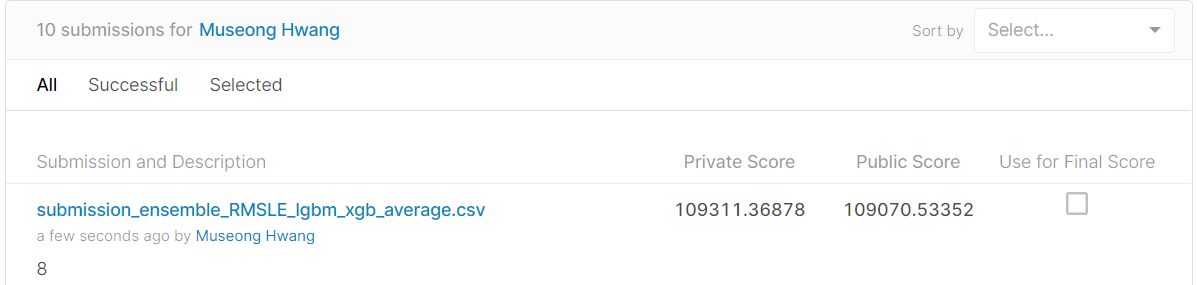


### 간단한 회고
* 파라미터 튜닝을 하는데 굉장히 오래 걸렸다. 튜닝을 하면 할수록 점수가 오르지만 절대적 시간이 소요되며, 한다고해서 비약적인 점수 상승은 어렵다.
* 애초에 성능자체를 좋게 만들고 싶으면 feature를 어떻게 가공하여 모델에 적용할 것인가가 절대적이다.


예제를 하면서 고민을 굉장히 많이했다. EDA부터 feature engineering을 진행하면 시간적 소요가 장난아닐 것 같아서 price에 대해서만 로그변환을 하고 나머지는 그대로 두었다. 왜냐하면 앙상블계열 모델자체가 다른모델에 비해 Robust하고 성능자체가 좋기 때문이다. 그래서 하이퍼파라미터에 대해서만 집중하였다.

하이퍼파라미터도 각 모델마다 개수가 상당했으며 튜닝 테스트를 진행시 어떻게 지정하는지에 따라 시간과 성능이 좌지우지 된다. 이것또한 경험이 쌓이다 보면 초기 파라미터를 잘 설정할 수 있지 않을까 생각한다.